# 캔들차트 데이터 생성


참고 : https://dataplay.tistory.com/37?category=845492

참고코드 : https://colab.research.google.com/drive/1WXG3cohwO6_0mbmB9CdT37cc1jfE2Zon

In [ ]:
pip install mpl_finance

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from shutil import copyfile, move
from mpl_finance import candlestick2_ochl

도지 코인 파일 불러오기


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
currentPath = os.getcwd()

#change path
os.chdir('/content/drive/MyDrive')

In [ ]:
coinbase = pd.read_csv("out_KRW-DOGE_min_1_2021-05-21.csv")

cb_index = coinbase.index.ravel() # 메모리에서 발생하는 순서대로 인덱싱하여 평평하게 배열

coinbase

,code,candleDateTime,candleDateTimeKst,openingPrice,highPrice,lowPrice,tradePrice,candleAccTradeVolume,candleAccTradePrice,timestamp,unit
0,CRIX.UPBIT.KRW-DOGE,2021-05-20T15:00:00+00:00,2021-05-21T00:00:00+09:00,516,517,515,516,2.901292e+06,1.498517e+09,1.621520e+12,1
1,CRIX.UPBIT.KRW-DOGE,2021-05-20T15:01:00+00:00,2021-05-21T00:01:00+09:00,517,517,515,517,2.739025e+06,1.413013e+09,1.621520e+12,1
2,CRIX.UPBIT.KRW-DOGE,2021-05-20T15:02:00+00:00,2021-05-21T00:02:00+09:00,516,518,516,517,3.068264e+06,1.585857e+09,1.621520e+12,1
3,CRIX.UPBIT.KRW-DOGE,2021-05-20T15:03:00+00:00,2021-05-21T00:03:00+09:00,517,519,517,518,3.167764e+06,1.642005e+09,1.621520e+12,1
4,CRIX.UPBIT.KRW-DOGE,2021-05-20T15:04:00+00:00,2021-05-21T00:04:00+09:00,519,520,517,518,4.111393e+06,2.131710e+09,1.621520e+12,1
...,...,...,...,...,...,...,...,...,...,...,...
10075,CRIX.UPBIT.KRW-DOGE,2021-05-27T14:55:00+00:00,2021-05-27T23:55:00+09:00,408,409,408,408,3.265581e+05,1.332449e+08,1.622130e+12,1
10076,CRIX.UPBIT.KRW-DOGE,2021-05-27T14:56:00+00:00,2021-05-27T23:56:00+09:00,408,409,408,408,6.259779e+05,2.554018e+08,1.622130e+12,1
10077,CRIX.UPBIT.KRW-DOGE,2021-05-27T14:57:00+00:00,2021-05-27T23:57:00+09:00,408,408,407,408,6.565523e+05,2.678439e+08,1.622130e+12,1
10078,CRIX.UPBIT.KRW-DOGE,2021-05-27T14:58:00+00:00,2021-05-27T23:58:00+09:00,408,408,407,407,3.526589e+05,1.438332e+08,1.622130e+12,1


In [ ]:
coinbase.isna().sum()

code                    0
candleDateTime          0
candleDateTimeKst       0
openingPrice            0
highPrice               0
lowPrice                0
tradePrice              0
candleAccTradeVolume    0
candleAccTradePrice     0
timestamp               0
unit                    0
dtype: int64

In [ ]:
data = coinbase.fillna(method="backfill") # 결측치를 뒷방향으로 채워나가는 것

In [ ]:
data = data.drop(columns=['code', 'candleDateTime', 'candleDateTimeKst', 'candleAccTradeVolume','candleAccTradePrice','timestamp','unit'], axis=1)

In [ ]:
data = data.reset_index(drop=True)

In [ ]:
data

,openingPrice,highPrice,lowPrice,tradePrice
0,516,517,515,516
1,517,517,515,517
2,516,518,516,517
3,517,519,517,518
4,519,520,517,518
...,...,...,...,...
10075,408,409,408,408
10076,408,409,408,408
10077,408,408,407,408
10078,408,408,407,407


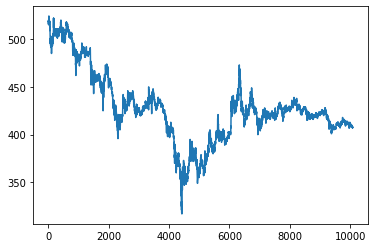

In [ ]:
plt.plot(data['tradePrice'])

In [ ]:
def ohlc2cs2(data, seq_len, dimension):
    # python preprocess.py -m ohlc2cs -l 20 -i stockdatas/EWT_testing.csv -t testing
    print("Converting olhc to candlestick")
    df = data
    plt.style.use('dark_background')
    figs = np.zeros((len(df)-1, dimension, dimension, 3))
    labels = []
    for i in range(0, len(df)-1):
        # ohlc+volume
        c = df.loc[i:i + int(seq_len) - 1, :]
        c_ = df.loc[i:i + int(seq_len), :]
        if len(c) == int(seq_len):
            my_dpi = 96
            fig = plt.figure(figsize=(dimension / my_dpi,
                                      dimension / my_dpi), dpi=my_dpi)
            ax1 = fig.add_subplot(1, 1, 1)
            candlestick2_ochl(ax1, c['openingPrice'], c['tradePrice'], c['highPrice'],
                              c['lowPrice'], width=1,
                              colorup='#77d879', colordown='#db3f3f')
            ax1.grid(False)
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
            ax1.xaxis.set_visible(False)
            ax1.yaxis.set_visible(False)
            ax1.axis('off')

            # create the second axis for the volume bar-plot
            # Add a seconds axis for the volume overlay

        starting = c_["tradePrice"].iloc[-2]
        endvalue = c_["tradePrice"].iloc[-1]
        if endvalue > starting :
            label = 1
        else :
            label = 0
        labels.append(label)

        fig.canvas.draw()
        fig_np = np.array(fig.canvas.renderer._renderer)
        figs[i] = fig_np[:,:,:3]

        plt.close(fig)
        # normal length - end

    print("Converting olhc to candlestik finished.")
    return figs, labels

In [ ]:
inputs = data
seq_len = 30
dimension = 48

figures, labels = ohlc2cs2(inputs, seq_len, dimension)

Converting olhc to candlestick
Converting olhc to candlestik finished.


In [ ]:
#위 함수로 생성된 figures는 값의 범위가 0~255 이기 때문에 0~1로 맞춰주기 위해 255로 나눕니다.
figures = figures/255.0
print(np.shape(labels), np.shape(figures))

(10079,) (10079, 48, 48, 3)


데이터 제너레이팅

In [ ]:
def single_stock_generator(chart, labels, batch_size) :
    #output [chart, labels]
    while True :
        stock_batch = np.zeros(shape=(batch_size, dimension, dimension, 3))
        label_batch = np.zeros(shape=(batch_size, ))
        for i in range(batch_size) :
            idx = np.random.randint(len(labels))
            stock_batch[i] = chart[idx]
            label_batch[i] = labels[idx]

        yield stock_batch, label_batch

In [ ]:
train_len = 6753
batch_size = 16
train_gen = single_stock_generator(figures[:train_len], labels[:train_len], batch_size)
test_gen = single_stock_generator(figures[train_len:], labels[train_len:], batch_size)


In [ ]:
tmp_data = next(train_gen)
print("Chart image shape : ",np.shape(tmp_data[0]))
print("Label shape :",np.shape(tmp_data[1]))

Chart image shape :  (16, 48, 48, 3)
Label shape : (16,)


In [ ]:
# 만들어진 차트 이미지 중 하나를 예시로 그려보겠습니다.
import matplotlib as mpl
import matplotlib.pylab as plt
%matplotlib inline

In [ ]:
len(tmp_data[0][0][:,:,:])

48

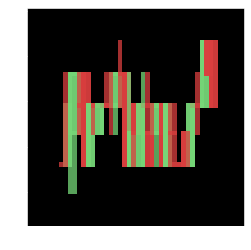

In [ ]:
plt.figure()
plt.imshow(tmp_data[0][15][:,:,:])
plt.show()

# 모듈, 라이브러리 설치

In [ ]:
# Keras의 Functional APi를 이용할 거라서 불러와줍니다.
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed

import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix, mean_squared_error

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas import get_dummies
import xgboost as xgb
import scipy
import math
import json
import sys
import csv
import os
import tqdm
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
from tqdm import tqdm_notebook



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, ConvLSTM2D, Flatten
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ANN


참고 코드 : https://colab.research.google.com/drive/1rIylR9RWEckndbyFNx1Wl_yUQZUF-wyI#scrollTo=70zNPAmbZcGh

In [ ]:
inputs = keras.Input(shape=(48, 48, 3))
x = inputs
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(1, activation='sigmoid')(x)
outputs = x

ANN = keras.Model(inputs, outputs)
ANN.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 6912)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                221216    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 221,249
Trainable params: 221,249
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#정확도
num_iters = train_len // batch_size
num_epochs = 11
optimizer = tf.keras.optimizers.Adam(0.0001)
loss_fn = tf.keras.losses.BinaryCrossentropy()
acc_fn = tf.keras.metrics.BinaryAccuracy()
num_test_iters = num_iters // 4

for epoch in range(num_epochs) :
    epoch_loss_avg = tf.keras.metrics.Mean()
    val_loss_avg = tf.keras.metrics.Mean()
    epoch_acc_avg = tf.keras.metrics.Mean()
    val_acc_avg = tf.keras.metrics.Mean()

    for iter in range(num_iters) :
        x_batch, y_batch = next(train_gen)
        y_batch = y_batch.reshape(-1,1)
        y_ = ANN(x_batch)
        loss_value = loss_fn(y_batch, y_)
        acc_value = acc_fn(y_batch, y_)
        epoch_loss_avg(loss_value)
        epoch_acc_avg(acc_value)

    for iter in range(num_test_iters) :
        x_batch, y_batch = next(test_gen)
        y_batch = y_batch.reshape(-1,1)
        y_= ANN(x_batch)
        loss_value2 = loss_fn(y_batch, y_)
        acc_value2 = acc_fn(y_batch, y_)
        val_loss_avg(loss_value2)
        val_acc_avg(acc_value2)



    print("Epoch {:03d}: , Train Loss: {:.5f} , Train acc: {:.5f}".format(epoch, epoch_loss_avg.result(), epoch_acc_avg.result()))
    print("Val_Loss: {:.3f}, Val_acc: {:.3f}".format(val_loss_avg.result(), val_acc_avg.result()))

ANN_loss = float(format(val_loss_avg.result()))
ANN_ACC = float(format(val_acc_avg.result()))

Epoch 000: , Train Loss: 0.67184 , Train acc: 0.60964
Val_Loss: 0.665, Val_acc: 0.608
Epoch 001: , Train Loss: 0.67218 , Train acc: 0.61103
Val_Loss: 0.667, Val_acc: 0.611
Epoch 002: , Train Loss: 0.67363 , Train acc: 0.60831
Val_Loss: 0.660, Val_acc: 0.609
Epoch 003: , Train Loss: 0.67360 , Train acc: 0.60933
Val_Loss: 0.663, Val_acc: 0.609
Epoch 004: , Train Loss: 0.66941 , Train acc: 0.60983
Val_Loss: 0.659, Val_acc: 0.610
Epoch 005: , Train Loss: 0.67358 , Train acc: 0.61110
Val_Loss: 0.662, Val_acc: 0.611
Epoch 006: , Train Loss: 0.67089 , Train acc: 0.61145
Val_Loss: 0.658, Val_acc: 0.612
Epoch 007: , Train Loss: 0.67448 , Train acc: 0.61256
Val_Loss: 0.660, Val_acc: 0.612
Epoch 008: , Train Loss: 0.67347 , Train acc: 0.61236
Val_Loss: 0.660, Val_acc: 0.612
Epoch 009: , Train Loss: 0.67502 , Train acc: 0.61189
Val_Loss: 0.665, Val_acc: 0.612
Epoch 010: , Train Loss: 0.67178 , Train acc: 0.61178
Val_Loss: 0.660, Val_acc: 0.612


In [ ]:
ANN_ACC

0.6120555400848389

# 1D CNN

In [ ]:
inputs = keras.Input(shape=(48, 48, 3))
x = inputs
x = layers.Conv1D(filters=32, kernel_size=5, padding="causal",activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
x = layers.Dense(1, activation='sigmoid')(x)
outputs = x

CNN1D = keras.Model(inputs, outputs)
CNN1D.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
conv1d (Conv1D)              (None, 48, 48, 32)        512       
_________________________________________________________________
flatten_6 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1179664   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 1,180,193
Trainable params: 1,180,193
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#정확도
num_iters = train_len // batch_size
num_epochs = 11
optimizer = tf.keras.optimizers.Adam(0.0001)
loss_fn = tf.keras.losses.BinaryCrossentropy()
acc_fn = tf.keras.metrics.BinaryAccuracy()
num_test_iters = num_iters // 4
for epoch in range(num_epochs) :
    epoch_loss_avg = tf.keras.metrics.Mean()
    val_loss_avg = tf.keras.metrics.Mean()
    epoch_acc_avg = tf.keras.metrics.Mean()
    val_acc_avg = tf.keras.metrics.Mean()

    for iter in range(num_iters) :
        x_batch, y_batch = next(train_gen)
        y_batch = y_batch.reshape(-1,1)
        y_ = CNN1D(x_batch)
        loss_value = loss_fn(y_batch, y_)
        acc_value = acc_fn(y_batch, y_)
        epoch_loss_avg(loss_value)
        epoch_acc_avg(acc_value)

    for iter in range(num_test_iters) :
        x_batch, y_batch = next(test_gen)
        y_batch = y_batch.reshape(-1,1)
        y_= CNN1D(x_batch)
        loss_value2 = loss_fn(y_batch, y_)
        acc_value2 = acc_fn(y_batch, y_)
        val_loss_avg(loss_value2)
        val_acc_avg(acc_value2)



    print("Epoch {:03d}: , Train Loss: {:.5f} , Train acc: {:.5f}".format(epoch, epoch_loss_avg.result(), epoch_acc_avg.result()))
    print("Val_Loss: {:.3f}, Val_acc: {:.3f}".format(val_loss_avg.result(), val_acc_avg.result()))

CNN1D_loss = float(format(val_loss_avg.result()))
CNN1D_ACC = float(format(val_acc_avg.result()))

Epoch 000: , Train Loss: 0.70311 , Train acc: 0.36974
Val_Loss: 0.708, Val_acc: 0.360
Epoch 001: , Train Loss: 0.70281 , Train acc: 0.35737
Val_Loss: 0.708, Val_acc: 0.358
Epoch 002: , Train Loss: 0.70412 , Train acc: 0.35578
Val_Loss: 0.708, Val_acc: 0.354
Epoch 003: , Train Loss: 0.70411 , Train acc: 0.35271
Val_Loss: 0.708, Val_acc: 0.352
Epoch 004: , Train Loss: 0.70353 , Train acc: 0.35079
Val_Loss: 0.707, Val_acc: 0.351
Epoch 005: , Train Loss: 0.70331 , Train acc: 0.35100
Val_Loss: 0.708, Val_acc: 0.351
Epoch 006: , Train Loss: 0.70350 , Train acc: 0.35082
Val_Loss: 0.706, Val_acc: 0.352
Epoch 007: , Train Loss: 0.70355 , Train acc: 0.35237
Val_Loss: 0.708, Val_acc: 0.353
Epoch 008: , Train Loss: 0.70370 , Train acc: 0.35237
Val_Loss: 0.709, Val_acc: 0.352
Epoch 009: , Train Loss: 0.70306 , Train acc: 0.35257
Val_Loss: 0.708, Val_acc: 0.352
Epoch 010: , Train Loss: 0.70348 , Train acc: 0.35233
Val_Loss: 0.707, Val_acc: 0.353


In [ ]:
CNN1D_ACC

0.35252845287323

# CNN

참고 논문 : Using Deep Learning Neural Networks and Candlestick chart Representation to Predict Stock Market
https://arxiv.org/pdf/1903.12258.pdf

다음날 종가가 상승이냐 아니냐를 맞추는 binary classification 문제

In [ ]:
inputs = keras.Input(shape=(48, 48, 3))
x = inputs
x = layers.Conv2D(48, 3, activation='relu', padding="same")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(rate=0.5)(x)
x = layers.Conv2D(96, 3, activation='relu', padding="same")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(rate=0.5)(x)
x = layers.Flatten()(x)
x = layers.Dense(1, activation='sigmoid')(x)
outputs = x

CNN = keras.Model(inputs, outputs)
CNN.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 48)        1344      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 48)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 48)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 96)        41568     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 96)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 96)        0   

In [ ]:
#정확도
num_iters = train_len // batch_size
num_epochs = 11
optimizer = tf.keras.optimizers.Adam(0.0001)
loss_fn = tf.keras.losses.BinaryCrossentropy()
acc_fn = tf.keras.metrics.BinaryAccuracy()
num_test_iters = num_iters // 4
for epoch in range(num_epochs) :
    epoch_loss_avg = tf.keras.metrics.Mean()
    val_loss_avg = tf.keras.metrics.Mean()
    epoch_acc_avg = tf.keras.metrics.Mean()
    val_acc_avg = tf.keras.metrics.Mean()

    for iter in range(num_iters) :
        x_batch, y_batch = next(train_gen)
        y_batch = y_batch.reshape(-1,1)
        y_ = CNN(x_batch)
        loss_value = loss_fn(y_batch, y_)
        acc_value = acc_fn(y_batch, y_)
        epoch_loss_avg(loss_value)
        epoch_acc_avg(acc_value)

    for iter in range(num_test_iters) :
        x_batch, y_batch = next(test_gen)
        y_batch = y_batch.reshape(-1,1)
        y_= CNN(x_batch)
        loss_value2 = loss_fn(y_batch, y_)
        acc_value2 = acc_fn(y_batch, y_)
        val_loss_avg(loss_value2)
        val_acc_avg(acc_value2)



    print("Epoch {:03d}: , Train Loss: {:.5f} , Train acc: {:.5f}".format(epoch, epoch_loss_avg.result(), epoch_acc_avg.result()))
    print("Val_Loss: {:.3f}, Val_acc: {:.3f}".format(val_loss_avg.result(), val_acc_avg.result()))

CNN_loss = float(format(val_loss_avg.result()))
CNN_ACC = float(format(val_acc_avg.result()))

Epoch 000: , Train Loss: 0.69415 , Train acc: 0.48890
Val_Loss: 0.696, Val_acc: 0.479
Epoch 001: , Train Loss: 0.69433 , Train acc: 0.47284
Val_Loss: 0.697, Val_acc: 0.473
Epoch 002: , Train Loss: 0.69454 , Train acc: 0.47127
Val_Loss: 0.696, Val_acc: 0.472
Epoch 003: , Train Loss: 0.69498 , Train acc: 0.46930
Val_Loss: 0.696, Val_acc: 0.469
Epoch 004: , Train Loss: 0.69466 , Train acc: 0.46862
Val_Loss: 0.696, Val_acc: 0.468
Epoch 005: , Train Loss: 0.69419 , Train acc: 0.46864
Val_Loss: 0.696, Val_acc: 0.469
Epoch 006: , Train Loss: 0.69434 , Train acc: 0.46950
Val_Loss: 0.696, Val_acc: 0.470
Epoch 007: , Train Loss: 0.69426 , Train acc: 0.46962
Val_Loss: 0.698, Val_acc: 0.469
Epoch 008: , Train Loss: 0.69419 , Train acc: 0.46919
Val_Loss: 0.697, Val_acc: 0.470
Epoch 009: , Train Loss: 0.69423 , Train acc: 0.46964
Val_Loss: 0.697, Val_acc: 0.470
Epoch 010: , Train Loss: 0.69461 , Train acc: 0.46935
Val_Loss: 0.697, Val_acc: 0.469


# GRU


소스코드 : https://github.com/zutshianand/Stock-Price-Prediction/blob/master/main.ipynb

In [ ]:
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(2304, 3), activation='tanh'))
# The output layer
regressorGRU.add(Dense(units=1))
regressorGRU.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 2304, 50)          8250      
_________________________________________________________________
dense (Dense)                (None, 2304, 1)           51        
Total params: 8,301
Trainable params: 8,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#정확도
num_iters = train_len // batch_size
num_epochs = 11
optimizer = tf.keras.optimizers.Adam(0.0001)
loss_fn = tf.keras.losses.BinaryCrossentropy()
acc_fn = tf.keras.metrics.BinaryAccuracy()
num_test_iters = num_iters // 4
for epoch in range(num_epochs) :
    epoch_loss_avg = tf.keras.metrics.Mean()
    val_loss_avg = tf.keras.metrics.Mean()
    epoch_acc_avg = tf.keras.metrics.Mean()
    val_acc_avg = tf.keras.metrics.Mean()

    for iter in range(num_iters) :
        x_batch, y_batch = next(train_gen)
        x_batch = x_batch.reshape(16, 2304, 3)
        epoch_loss_avg(loss_value)
        epoch_acc_avg(acc_value)

    for iter in range(num_test_iters) :
        x_batch, y_batch = next(test_gen)
        x_batch = x_batch.reshape(16, 2304, 3)
        y_= regressorGRU(x_batch)
        loss_value = loss_fn(y_batch, y_)
        acc_value = acc_fn(y_batch, y_)
        val_loss_avg(loss_value)
        val_acc_avg(acc_value)



    print("Epoch {:03d}: , Train Loss: {:.5f} , Train acc: {:.5f}".format(epoch, epoch_loss_avg.result(), epoch_acc_avg.result()))
    print("Val_Loss: {:.3f}, Val_acc: {:.3f}".format(val_loss_avg.result(), val_acc_avg.result()))

GRU_loss = float(format(val_loss_avg.result()))
GRU_ACC = float(format(val_acc_avg.result()))

Epoch 000: , Train Loss: 0.69558 , Train acc: 0.46962
Val_Loss: 0.815, Val_acc: 0.738
Epoch 001: , Train Loss: 0.77902 , Train acc: 0.73691
Val_Loss: 0.816, Val_acc: 0.740
Epoch 002: , Train Loss: 0.60716 , Train acc: 0.73661
Val_Loss: 0.858, Val_acc: 0.734
Epoch 003: , Train Loss: 1.12562 , Train acc: 0.73155
Val_Loss: 0.894, Val_acc: 0.729
Epoch 004: , Train Loss: 1.30173 , Train acc: 0.72574
Val_Loss: 0.845, Val_acc: 0.724
Epoch 005: , Train Loss: 0.42922 , Train acc: 0.72583
Val_Loss: 0.895, Val_acc: 0.724
Epoch 006: , Train Loss: 0.77460 , Train acc: 0.72282
Val_Loss: 0.842, Val_acc: 0.723
Epoch 007: , Train Loss: 0.95467 , Train acc: 0.72339
Val_Loss: 0.876, Val_acc: 0.723
Epoch 008: , Train Loss: 0.25697 , Train acc: 0.72232
Val_Loss: 0.851, Val_acc: 0.722
Epoch 009: , Train Loss: 0.42891 , Train acc: 0.72249
Val_Loss: 0.853, Val_acc: 0.722
Epoch 010: , Train Loss: 0.60341 , Train acc: 0.72250
Val_Loss: 0.849, Val_acc: 0.723


In [ ]:
GRU_ACC

0.7225949764251709

# LSTM

shape 확인 기존 48,48,3 -> 48,3으로 변경

In [ ]:
inputs = keras.Input(shape=(2304, 3))
x = inputs
# First LSTM layer with Dropout regularisation
x = layers.LSTM(units=32, return_sequences=True)(x)
x = layers.Dropout(rate=0.5)(x)
# Second LSTM layer
x = layers.LSTM(units=32, return_sequences=True)(x)
x = layers.Dropout(rate=0.5)(x)
# Third LSTM layer
x = layers.LSTM(units=32, return_sequences=True)(x)
x = layers.Dropout(rate=0.5)(x)
# Fourth LSTM layer
x = layers.LSTM(units=32, return_sequences=True)(x)
x = layers.Dropout(rate=0.5)(x)
# The output layer
x = layers.Dense(1)(x)
outputs = x

LSTM = keras.Model(inputs, outputs)
LSTM.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 2304, 3)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 2304, 32)          4608      
_________________________________________________________________
dropout_2 (Dropout)          (None, 2304, 32)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 2304, 32)          8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 2304, 32)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 2304, 32)          8320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 2304, 32)          0   

In [ ]:
#정확도
num_iters = train_len // batch_size
num_epochs = 11
optimizer = tf.keras.optimizers.Adam(0.0001)
loss_fn = tf.keras.losses.BinaryCrossentropy()
acc_fn = tf.keras.metrics.BinaryAccuracy()
num_test_iters = num_iters // 4
for epoch in range(num_epochs) :
    epoch_loss_avg = tf.keras.metrics.Mean()
    val_loss_avg = tf.keras.metrics.Mean()
    epoch_acc_avg = tf.keras.metrics.Mean()
    val_acc_avg = tf.keras.metrics.Mean()

    for iter in range(num_iters) :
        x_batch, y_batch = next(train_gen)
        x_batch = x_batch.reshape(16, 2304, 3)
        y_ = LSTM(x_batch)
        loss_value = loss_fn(y_batch, y_)
        acc_value = acc_fn(y_batch, y_)
        epoch_loss_avg.update_state(loss_value)
        epoch_acc_avg(acc_value)

    for iter in range(num_test_iters) :
        x_batch, y_batch = next(test_gen)
        x_batch = x_batch.reshape(16, 2304, 3)
        y_= LSTM(x_batch)
        loss_value2 = loss_fn(y_batch, y_)
        acc_value2 = acc_fn(y_batch, y_)
        val_loss_avg.update_state(loss_value2)
        val_acc_avg(acc_value2)



    print("Epoch {:03d}: , Train Loss: {:.5f} , Train acc: {:.5f}".format(epoch, epoch_loss_avg.result(), epoch_acc_avg.result()))
    print("Val_Loss: {:.3f}, Val_acc: {:.3f}".format(val_loss_avg.result(), val_acc_avg.result()))

LSTM_loss = float(format(val_loss_avg.result()))
LSTM_ACC = float(format(val_acc_avg.result()))

Epoch 000: , Train Loss: 5.29175 , Train acc: 0.64997
Val_Loss: 4.267, Val_acc: 0.663
Epoch 001: , Train Loss: 5.35570 , Train acc: 0.66593
Val_Loss: 4.432, Val_acc: 0.665
Epoch 002: , Train Loss: 5.40365 , Train acc: 0.66373
Val_Loss: 4.349, Val_acc: 0.664
Epoch 003: , Train Loss: 5.47678 , Train acc: 0.66363
Val_Loss: 4.092, Val_acc: 0.664
Epoch 004: , Train Loss: 5.39686 , Train acc: 0.66377
Val_Loss: 4.065, Val_acc: 0.664
Epoch 005: , Train Loss: 5.46532 , Train acc: 0.66382
Val_Loss: 4.542, Val_acc: 0.663
Epoch 006: , Train Loss: 5.24390 , Train acc: 0.66382
Val_Loss: 4.588, Val_acc: 0.664
Epoch 007: , Train Loss: 5.24620 , Train acc: 0.66438
Val_Loss: 4.413, Val_acc: 0.665
Epoch 008: , Train Loss: 5.52004 , Train acc: 0.66437
Val_Loss: 4.404, Val_acc: 0.664
Epoch 009: , Train Loss: 5.33979 , Train acc: 0.66377
Val_Loss: 4.505, Val_acc: 0.664
Epoch 010: , Train Loss: 5.41288 , Train acc: 0.66370
Val_Loss: 4.377, Val_acc: 0.664


In [ ]:
LSTM_ACC

0.6637458205223083

# BLSTM

소스코드 : https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/

In [ ]:
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed

In [ ]:
BL = Sequential()
BL.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(2304, 3)))
BL.add(TimeDistributed(Dense(1, activation='sigmoid')))
BL.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 2304, 40)          3840      
_________________________________________________________________
time_distributed (TimeDistri (None, 2304, 1)           41        
Total params: 3,881
Trainable params: 3,881
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#정확도
num_iters = train_len // batch_size
num_epochs = 11
optimizer = tf.keras.optimizers.Adam(0.0001)
loss_fn = tf.keras.losses.BinaryCrossentropy()
acc_fn = tf.keras.metrics.BinaryAccuracy()
num_test_iters = num_iters // 4
for epoch in range(num_epochs) :
    epoch_loss_avg = tf.keras.metrics.Mean()
    val_loss_avg = tf.keras.metrics.Mean()
    epoch_acc_avg = tf.keras.metrics.Mean()
    val_acc_avg = tf.keras.metrics.Mean()

    for iter in range(num_iters) :
        x_batch, y_batch = next(train_gen)
        x_batch = x_batch.reshape(16, 2304, 3)
        y_ = BL(x_batch)
        loss_value = loss_fn(y_batch, y_)
        acc_value = acc_fn(y_batch, y_)
        epoch_loss_avg(loss_value)
        epoch_acc_avg(acc_value)

    for iter in range(num_test_iters) :
        x_batch, y_batch = next(test_gen)
        x_batch = x_batch.reshape(16, 2304, 3)
        y_= BL(x_batch)
        loss_value2 = loss_fn(y_batch, y_)
        acc_value = acc_fn(y_batch, y_)
        val_loss_avg(loss_value2)
        val_acc_avg(acc_value)



    print("Epoch {:03d}: , Train Loss: {:.5f} , Train acc: {:.5f}".format(epoch, epoch_loss_avg.result(), epoch_acc_avg.result()))
    print("Val_Loss: {:.3f}, Val_acc: {:.3f}".format(val_loss_avg.result(), val_acc_avg.result()))

BLSTM_loss = float(format(val_loss_avg.result()))
BLSTM_ACC = float(format(val_acc_avg.result()))

Epoch 000: , Train Loss: 0.65370 , Train acc: 0.65442
Val_Loss: 0.627, Val_acc: 0.660
Epoch 001: , Train Loss: 0.65061 , Train acc: 0.66257
Val_Loss: 0.628, Val_acc: 0.666
Epoch 002: , Train Loss: 0.65201 , Train acc: 0.66768
Val_Loss: 0.629, Val_acc: 0.667
Epoch 003: , Train Loss: 0.65358 , Train acc: 0.66674
Val_Loss: 0.633, Val_acc: 0.666
Epoch 004: , Train Loss: 0.65543 , Train acc: 0.66505
Val_Loss: 0.633, Val_acc: 0.665
Epoch 005: , Train Loss: 0.65471 , Train acc: 0.66459
Val_Loss: 0.630, Val_acc: 0.664
Epoch 006: , Train Loss: 0.65655 , Train acc: 0.66350
Val_Loss: 0.631, Val_acc: 0.663
Epoch 007: , Train Loss: 0.65330 , Train acc: 0.66351
Val_Loss: 0.631, Val_acc: 0.663
Epoch 008: , Train Loss: 0.65235 , Train acc: 0.66393
Val_Loss: 0.627, Val_acc: 0.664
Epoch 009: , Train Loss: 0.65443 , Train acc: 0.66384
Val_Loss: 0.635, Val_acc: 0.664
Epoch 010: , Train Loss: 0.65280 , Train acc: 0.66389
Val_Loss: 0.631, Val_acc: 0.664


In [ ]:
BLSTM_ACC

0.663852870464325

# Convlstm2D

참고 : https://deep-deep-deep.tistory.com/32 [딥딥딥]

소스 코드 : https://keras.io/examples/vision/conv_lstm/

CNN 관련 : http://taewan.kim/post/cnn/

In [ ]:
seq = keras.Sequential(
    [
        keras.Input(
            shape=(48, 48, 3, 1)
        ),  # Variable-length sequence of 40x40x1 frames
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True

        ),
        layers.BatchNormalization(),
        layers.Conv3D(
            filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
        ),
    ]
)
seq.compile(loss="binary_crossentropy", optimizer="adadelta")

In [ ]:
seq.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 48, 48, 3, 40)     59200     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 3, 40)     160       
_________________________________________________________________
conv3d (Conv3D)              (None, 48, 48, 3, 1)      1081      
Total params: 60,441
Trainable params: 60,361
Non-trainable params: 80
_________________________________________________________________


In [ ]:
#정확도
num_iters = train_len // batch_size
num_epochs = 11
optimizer = tf.keras.optimizers.Adam(0.0001)
loss_fn = tf.keras.losses.BinaryCrossentropy()
acc_fn = tf.keras.metrics.BinaryAccuracy()
num_test_iters = num_iters // 4
for epoch in range(num_epochs) :
    epoch_loss_avg = tf.keras.metrics.Mean()
    val_loss_avg = tf.keras.metrics.Mean()
    epoch_acc_avg = tf.keras.metrics.Mean()
    val_acc_avg = tf.keras.metrics.Mean()

    for iter in range(num_iters) :
        x_batch, y_batch = next(train_gen)
        x_batch = x_batch.reshape(16, 48, 48, 3, 1)
        y_ = seq(x_batch)[0]
        loss_value = loss_fn(y_batch, y_)
        acc_value = acc_fn(y_batch, y_)
        epoch_loss_avg(loss_value)
        epoch_acc_avg(acc_value)

    for iter in range(num_test_iters) :
        x_batch, y_batch = next(test_gen)
        x_batch = x_batch.reshape(16, 48, 48, 3, 1)
        y_= seq(x_batch)[0]
        loss_value = loss_fn(y_batch, y_)
        acc_value = acc_fn(y_batch, y_)
        val_loss_avg(loss_value)
        val_acc_avg(acc_value)



    print("Epoch {:03d}: , Train Loss: {:.5f} , Train acc: {:.5f}".format(epoch, epoch_loss_avg.result(), epoch_acc_avg.result()))
    print("Val_Loss: {:.3f}, Val_acc: {:.3f}".format(val_loss_avg.result(), val_acc_avg.result()))

Convlstm2D_loss = float(format(val_loss_avg.result()))
Convlstm2D_acc = float(format(val_acc_avg.result()))

Epoch 000: , Train Loss: 0.69231 , Train acc: 0.58355
Val_Loss: 0.692, Val_acc: 0.586
Epoch 001: , Train Loss: 0.69222 , Train acc: 0.58798
Val_Loss: 0.692, Val_acc: 0.589
Epoch 002: , Train Loss: 0.69228 , Train acc: 0.58862
Val_Loss: 0.692, Val_acc: 0.590
Epoch 003: , Train Loss: 0.69226 , Train acc: 0.58921
Val_Loss: 0.692, Val_acc: 0.590
Epoch 004: , Train Loss: 0.69236 , Train acc: 0.58846
Val_Loss: 0.691, Val_acc: 0.588
Epoch 005: , Train Loss: 0.69233 , Train acc: 0.58836
Val_Loss: 0.692, Val_acc: 0.588
Epoch 006: , Train Loss: 0.69228 , Train acc: 0.58839
Val_Loss: 0.692, Val_acc: 0.588
Epoch 007: , Train Loss: 0.69223 , Train acc: 0.58875
Val_Loss: 0.692, Val_acc: 0.589
Epoch 008: , Train Loss: 0.69232 , Train acc: 0.58891
Val_Loss: 0.692, Val_acc: 0.589
Epoch 009: , Train Loss: 0.69224 , Train acc: 0.58887
Val_Loss: 0.692, Val_acc: 0.589
Epoch 010: , Train Loss: 0.69231 , Train acc: 0.58870
Val_Loss: 0.692, Val_acc: 0.589


In [ ]:
Convlstm2D_acc

0.5886179208755493

 # CNN-LSTM

소스 코드 : https://colab.research.google.com/drive/1rIylR9RWEckndbyFNx1Wl_yUQZUF-wyI#scrollTo=M1QKFdJOYTjx

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, ConvLSTM2D, Flatten
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
inputs = keras.Input(shape=(2304, 3))
x = inputs
# 1차원 feature map 생성
x = layers.Conv1D(filters=32, kernel_size=5, padding="causal", activation="relu")(x)
# LSTM
x = layers.LSTM(16, activation='tanh')(x)
x = layers.Dense(16, activation="relu")(x)
x = layers.Dense(1, activation='sigmoid')(x)
outputs = x

M10 = keras.Model(inputs, outputs)
M10.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 2304, 3)]         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2304, 32)          512       
_________________________________________________________________
lstm_4 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 3,937
Trainable params: 3,937
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#정확도
num_iters = train_len // batch_size
num_epochs = 11
optimizer = tf.keras.optimizers.Adam(0.0001)
loss_fn = tf.keras.losses.BinaryCrossentropy()
acc_fn = tf.keras.metrics.BinaryAccuracy()
num_test_iters = num_iters // 4
for epoch in range(num_epochs) :
    epoch_loss_avg = tf.keras.metrics.Mean()
    val_loss_avg = tf.keras.metrics.Mean()
    epoch_acc_avg = tf.keras.metrics.Mean()
    val_acc_avg = tf.keras.metrics.Mean()

    for iter in range(num_iters) :
        x_batch, y_batch = next(train_gen)
        x_batch = x_batch.reshape(16, 2304, 3)
        y_ = M10(x_batch)
        y_batch = y_batch.reshape(-1,1)
        loss_value = loss_fn(y_batch, y_)
        acc_value = acc_fn(y_batch, y_)
        epoch_loss_avg(loss_value)
        epoch_acc_avg(acc_value)

    for iter in range(num_test_iters) :
        x_batch, y_batch = next(test_gen)
        x_batch = x_batch.reshape(16, 2304, 3)
        y_= M10(x_batch)
        y_batch = y_batch.reshape(-1,1)
        loss_value = loss_fn(y_batch, y_)
        acc_value = acc_fn(y_batch, y_)
        val_loss_avg(loss_value)
        val_acc_avg(acc_value)



    print("Epoch {:03d}: , Train Loss: {:.5f} , Train acc: {:.5f}".format(epoch, epoch_loss_avg.result(), epoch_acc_avg.result()))
    print("Val_Loss: {:.3f}, Val_acc: {:.3f}".format(val_loss_avg.result(), val_acc_avg.result()))

CNN_LSTM_loss = float(format(val_loss_avg.result()))
CNN_LSTM_ACC = float(format(val_acc_avg.result()))

Epoch 000: , Train Loss: 0.70154 , Train acc: 0.35843
Val_Loss: 0.705, Val_acc: 0.352
Epoch 001: , Train Loss: 0.70225 , Train acc: 0.34817
Val_Loss: 0.705, Val_acc: 0.345
Epoch 002: , Train Loss: 0.70160 , Train acc: 0.34590
Val_Loss: 0.705, Val_acc: 0.346
Epoch 003: , Train Loss: 0.70181 , Train acc: 0.34554
Val_Loss: 0.706, Val_acc: 0.345
Epoch 004: , Train Loss: 0.70225 , Train acc: 0.34263
Val_Loss: 0.705, Val_acc: 0.343
Epoch 005: , Train Loss: 0.70120 , Train acc: 0.34261
Val_Loss: 0.705, Val_acc: 0.343
Epoch 006: , Train Loss: 0.70198 , Train acc: 0.34320
Val_Loss: 0.706, Val_acc: 0.343
Epoch 007: , Train Loss: 0.70141 , Train acc: 0.34269
Val_Loss: 0.706, Val_acc: 0.343
Epoch 008: , Train Loss: 0.70196 , Train acc: 0.34292
Val_Loss: 0.706, Val_acc: 0.343
Epoch 009: , Train Loss: 0.70195 , Train acc: 0.34244
Val_Loss: 0.706, Val_acc: 0.342
Epoch 010: , Train Loss: 0.70239 , Train acc: 0.34141
Val_Loss: 0.705, Val_acc: 0.341


In [ ]:
CNN_LSTM_ACC

0.3412701189517975

# CNN-BLSTM

In [ ]:
from random import random
from numpy import array
from numpy import cumsum
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from random import random
from numpy import array
from numpy import cumsum
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional

In [ ]:
inputs = keras.Input(shape=(2304, 3))
x = inputs
# 1차원 feature map 생성
x = layers.Conv1D(filters=32, kernel_size=5, padding="causal", activation="relu")(x)
# LSTM
x = layers.Bidirectional(LSTM(20, return_sequences=True))(x)
x = layers.TimeDistributed(Dense(1, activation='sigmoid'))(x)
outputs = x

M11 = keras.Model(inputs, outputs)
M11.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 2304, 3)]         0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 2304, 32)          512       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 2304, 40)          8480      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 2304, 1)           41        
Total params: 9,033
Trainable params: 9,033
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#정확도
num_iters = train_len // batch_size
num_epochs = 11
optimizer = tf.keras.optimizers.Adam(0.0001)
loss_fn = tf.keras.losses.BinaryCrossentropy()
acc_fn = tf.keras.metrics.BinaryAccuracy()
num_test_iters = num_iters // 4
for epoch in range(num_epochs) :
    epoch_loss_avg = tf.keras.metrics.Mean()
    val_loss_avg = tf.keras.metrics.Mean()
    epoch_acc_avg = tf.keras.metrics.Mean()
    val_acc_avg = tf.keras.metrics.Mean()

    for iter in range(num_iters) :
        x_batch, y_batch = next(train_gen)
        x_batch = x_batch.reshape(16, 2304, 3)
        y_ = M11(x_batch)
        loss_value = loss_fn(y_batch, y_)
        acc_value = acc_fn(y_batch, y_)
        epoch_loss_avg(loss_value)
        epoch_acc_avg(acc_value)

    for iter in range(num_test_iters) :
        x_batch, y_batch = next(test_gen)
        x_batch = x_batch.reshape(16, 2304, 3)
        y_= M11(x_batch)
        loss_value = loss_fn(y_batch, y_)
        acc_value = acc_fn(y_batch, y_)
        val_loss_avg(loss_value)
        val_acc_avg(acc_value)



    print("Epoch {:03d}: , Train Loss: {:.5f} , Train acc: {:.5f}".format(epoch, epoch_loss_avg.result(), epoch_acc_avg.result()))
    print("Val_Loss: {:.3f}, Val_acc: {:.3f}".format(val_loss_avg.result(), val_acc_avg.result()))

CNN_BLSTM_loss = float(format(val_loss_avg.result()))
CNN_BLSTM_ACC = float(format(val_acc_avg.result()))

Epoch 000: , Train Loss: 0.67760 , Train acc: 0.64400
Val_Loss: 0.671, Val_acc: 0.661
Epoch 001: , Train Loss: 0.67742 , Train acc: 0.66345
Val_Loss: 0.670, Val_acc: 0.665
Epoch 002: , Train Loss: 0.67743 , Train acc: 0.66646
Val_Loss: 0.671, Val_acc: 0.666
Epoch 003: , Train Loss: 0.67811 , Train acc: 0.66625
Val_Loss: 0.671, Val_acc: 0.665
Epoch 004: , Train Loss: 0.67749 , Train acc: 0.66563
Val_Loss: 0.672, Val_acc: 0.666
Epoch 005: , Train Loss: 0.67813 , Train acc: 0.66504
Val_Loss: 0.670, Val_acc: 0.665
Epoch 006: , Train Loss: 0.67816 , Train acc: 0.66482
Val_Loss: 0.669, Val_acc: 0.665
Epoch 007: , Train Loss: 0.67608 , Train acc: 0.66591
Val_Loss: 0.669, Val_acc: 0.667
Epoch 008: , Train Loss: 0.67762 , Train acc: 0.66678
Val_Loss: 0.669, Val_acc: 0.667
Epoch 009: , Train Loss: 0.67806 , Train acc: 0.66714
Val_Loss: 0.670, Val_acc: 0.667
Epoch 010: , Train Loss: 0.67829 , Train acc: 0.66691
Val_Loss: 0.669, Val_acc: 0.667


In [ ]:
CNN_BLSTM_ACC

0.6668331623077393

# Model Comparison

In [ ]:
models = pd.DataFrame({
    'Model': ['CNN','ANN', 'GRU', '1D CNN', 'LSTM', 'BLSTM', 'Convlstm2D', 'CNN-LSTM ','CNN-BLSTM'],
    'Score': [CNN_ACC, ANN_ACC, GRU_ACC, CNN1D_ACC, LSTM_ACC, BLSTM_ACC, Convlstm2D_acc, CNN_LSTM_ACC, CNN_BLSTM_ACC]})
models.sort_values (by='Score', ascending=False)

,Model,Score
2,GRU,0.722595
8,CNN-BLSTM,0.666833
5,BLSTM,0.663853
4,LSTM,0.663746
1,ANN,0.612056
6,Convlstm2D,0.588618
0,CNN,0.469211
3,1D CNN,0.352528
7,CNN-LSTM,0.341270
